<a href="https://colab.research.google.com/github/joheras/PollenChallenge/blob/master/PollenChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pollen challenge

We first download the dataset

In [1]:
!wget https://www.dropbox.com/s/3aqsypyc0bopch5/pollen.zip?dl=1 -O pollen.zip
!unzip pollen.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: pollen/train/3/20190404114512_OBJ_38_1136_250.png  
  inflating: pollen/train/3/20190404114516_OBJ_28_1222_247.png  
  inflating: pollen/train/3/20190404114522_OBJ_0_540_899.png  
  inflating: pollen/train/3/20190404114522_OBJ_11_433_633.png  
  inflating: pollen/train/3/20190404114522_OBJ_27_779_227.png  
  inflating: pollen/train/3/20190404114522_OBJ_38_827_66.png  
  inflating: pollen/train/3/20190404114527_OBJ_2_117_874.png  
  inflating: pollen/train/3/20190404114527_OBJ_39_722_145.png  
  inflating: pollen/train/3/20190404114527_OBJ_9_89_786.png  
  inflating: pollen/train/3/20190404114531_OBJ_0_493_873.png  
  inflating: pollen/train/3/20190404114531_OBJ_19_475_471.png  
  inflating: pollen/train/3/20190404114531_OBJ_24_1094_460.png  
  inflating: pollen/train/3/20190404114531_OBJ_28_996_406.png  
  inflating: pollen/train/3/20190404114531_OBJ_46_798_72.png  
  inflating: pollen/train/3/20190404114531_OBJ_

Load the fastai library.

In [2]:
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [3]:
dataset = 'pollen'

We apply some data augmentation techniques, and load the dataset.

In [4]:
data=ImageDataBunch.from_folder(dataset,valid_pct=0.2,
        ds_tfms=get_transforms(), size=84,bs=32).normalize(imagenet_stats)

We define three modes for training the models. 

In [5]:
def learn_with_model(model):
  learn = cnn_learner(data, model, metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=3)])
  learn.fit_one_cycle(2)
  learn.unfreeze()
  learn.lr_find()
  lr=learn.recorder.lrs[np.argmin(learn.recorder.losses)]
  if lr<1e-05:
    lr=1e-03
  learn.fit_one_cycle(20,max_lr=slice(lr/100,lr))
  return learn

In [6]:
def learn_with_model_imbalanced(model):
  learn = cnn_learner(data, model, metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5)])
  weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
  class_weights=torch.FloatTensor(weights).cuda()
  learn.crit = nn.CrossEntropyLoss(weight=class_weights)
  learn.fit_one_cycle(2)
  learn.unfreeze()
  learn.lr_find()
  lr=learn.recorder.lrs[np.argmin(learn.recorder.losses)]
  if lr<1e-05:
    lr=1e-03
  learn.fit_one_cycle(20,max_lr=slice(lr/100,lr),callbacks=[callbacks.tracker.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])
  return learn



In [7]:
def learn_with_model_labelsmoothing(model):
  learn = cnn_learner(data, model, metrics=[accuracy,FBeta(average='macro',beta=1)], loss_func=LabelSmoothingCrossEntropy(), callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=3)])
  learn.fit_one_cycle(2)
  learn.unfreeze()
  learn.lr_find()
  lr=learn.recorder.lrs[np.argmin(learn.recorder.losses)]
  if lr<1e-05:
    lr=1e-03
  learn.fit_one_cycle(20,max_lr=slice(lr/100,lr),callbacks=[callbacks.tracker.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])
  return learn

We study several backbones. 

# Resnet 34

## Normal training

In [ ]:
learnResnet34 = learn_with_model(models.resnet34)
interp = ClassificationInterpretation.from_learner(learnResnet34)
interp.plot_confusion_matrix()

## Weighted loss

In [ ]:
learnResnet34_im = learn_with_model_imbalanced(models.resnet34)
interp = ClassificationInterpretation.from_learner(learnResnet34_im)
interp.plot_confusion_matrix()

## LabelSmoothing

In [ ]:
learnResnet34_ls = learn_with_model_labelsmoothing(models.resnet34)
interp = ClassificationInterpretation.from_learner(learnResnet34_ls)
interp.plot_confusion_matrix()

# Resnet 50

## Normal training

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.602004,0.450167,0.842572,0.700532,00:28
1,0.402197,0.386929,0.865632,0.774184,00:27


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.337594,0.319303,0.885588,0.810252,00:30
1,0.299824,0.271505,0.909091,0.854838,00:30
2,0.243287,0.246438,0.927716,0.870784,00:30
3,0.226812,0.239746,0.925055,0.873407,00:30
4,0.251796,0.189135,0.943237,0.902232,00:30
5,0.228132,0.206149,0.928160,0.883605,00:30
6,0.164880,0.203451,0.937916,0.898714,00:30
7,0.179847,0.325602,0.879823,0.856948,00:30


Epoch 8: early stopping


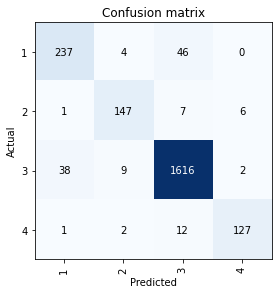

In [8]:
learnResnet50 = learn_with_model(models.resnet50)
interp = ClassificationInterpretation.from_learner(learnResnet50)
interp.plot_confusion_matrix()

## Weighted loss

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.629671,0.445982,0.846120,0.727411,00:27
1,0.385312,0.364790,0.875388,0.794747,00:26


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.329373,0.325700,0.880266,0.808104,00:30
1,0.288604,0.239492,0.922395,0.863042,00:30
2,0.256925,0.241014,0.922395,0.877561,00:29
3,0.226916,0.239425,0.931264,0.881199,00:30
4,0.239075,0.467930,0.833259,0.797980,00:32
5,0.222556,0.204581,0.941907,0.893495,00:31
6,0.210273,0.242981,0.925055,0.886399,00:31
7,0.169755,0.201020,0.943681,0.901354,00:31
8,0.142674,0.215296,0.943237,0.898841,00:30
9,0.124481,0.205845,0.938803,0.904209,00:30


Better model found at epoch 0 with accuracy value: 0.8802660703659058.
Better model found at epoch 1 with accuracy value: 0.9223946928977966.
Better model found at epoch 3 with accuracy value: 0.9312638640403748.
Better model found at epoch 5 with accuracy value: 0.9419068694114685.
Better model found at epoch 7 with accuracy value: 0.9436807036399841.
Epoch 11: early stopping
Better model found at epoch 11 with accuracy value: 0.9529933333396912.


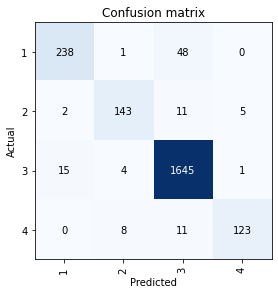

In [10]:
learnResnet50_im = learn_with_model_imbalanced(models.resnet50)
interp = ClassificationInterpretation.from_learner(learnResnet50_im)
interp.plot_confusion_matrix()

## Labelsmoothing

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.831715,0.685519,0.849667,0.729936,00:27
1,0.635828,0.615051,0.873614,0.783126,00:27


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.595697,0.588265,0.891353,0.823427,00:30
1,0.566468,0.523757,0.921951,0.867460,00:30
2,0.526896,0.498491,0.935255,0.895771,00:30
3,0.534550,0.488997,0.940576,0.899809,00:30
4,0.509329,0.517507,0.929933,0.879653,00:30
5,0.499161,0.497858,0.928603,0.884830,00:30


Better model found at epoch 0 with accuracy value: 0.8913525342941284.
Better model found at epoch 1 with accuracy value: 0.9219512343406677.
Better model found at epoch 2 with accuracy value: 0.9352549910545349.
Better model found at epoch 3 with accuracy value: 0.9405764937400818.
Epoch 6: early stopping


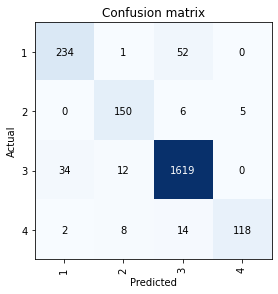

In [9]:
learnResnet50_ls = learn_with_model_labelsmoothing(models.resnet50)
interp = ClassificationInterpretation.from_learner(learnResnet50_ls)
interp.plot_confusion_matrix()

# Resnet 101

## Normal training

In [ ]:
learnResnet101 = learn_with_model_imbalanced(models.resnet101)
interp = ClassificationInterpretation.from_learner(learnResnet101)
interp.plot_confusion_matrix()

## Weighted loss


In [ ]:
learnResnet101_im = learn_with_model_imbalanced(models.resnet101)
interp = ClassificationInterpretation.from_learner(learnResnet101_im)
interp.plot_confusion_matrix()

## LabelSmoothing

In [ ]:
learnResnet101_ls = learn_with_model_labelsmoothing(models.resnet101)
interp = ClassificationInterpretation.from_learner(learnResnet101_ls)
interp.plot_confusion_matrix()

# Densenet 121

## Normal training

In [ ]:
learnDensenet121 = learn_with_model_imbalanced(models.densenet121)
interp = ClassificationInterpretation.from_learner(learnDensenet121)
interp.plot_confusion_matrix()

## Weighted loss

In [ ]:
learnDensenet121_im = learn_with_model_imbalanced(models.densenet121)
interp = ClassificationInterpretation.from_learner(learnDensenet121_im)
interp.plot_confusion_matrix()

## LabelSmoothing

In [ ]:
learnDensenet121_ls = learn_with_model_labelsmoothing(models.densenet121)
interp = ClassificationInterpretation.from_learner(learnDensenet121_ls)
interp.plot_confusion_matrix()

# Efficientnet B1

## Install additional libraries

In [11]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=8c81b97ebbfcbc5f47c1be6944328b61a297b38ebab1ab9195a0eb38ade098ed
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [12]:
import shutil
from fastai.vision import *
from fastai.vision import *
import os
import shutil
import glob
import random
from fastai.utils.mem import *
from fastai.vision.models import efficientnet

## Normal training

Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.346770,0.402221,0.920621,0.851165,00:43
1,0.263289,0.283052,0.930820,0.875413,00:43
2,0.244157,0.478948,0.857206,0.787846,00:43
3,0.213683,0.281016,0.930820,0.876803,00:43
4,0.183846,0.206130,0.946785,0.911476,00:43
5,0.181013,0.357405,0.926386,0.890170,00:43
6,0.155793,0.205173,0.937029,0.903737,00:42
7,0.165667,0.214182,0.949889,0.915963,00:42
8,0.132867,0.306729,0.893126,0.850594,00:42
9,0.144142,0.204015,0.932594,0.895838,00:42


Better model found at epoch 0 with accuracy value: 0.920620858669281.
Better model found at epoch 1 with accuracy value: 0.9308204054832458.
Better model found at epoch 4 with accuracy value: 0.9467849135398865.
Better model found at epoch 7 with accuracy value: 0.9498891234397888.
Epoch 10: early stopping


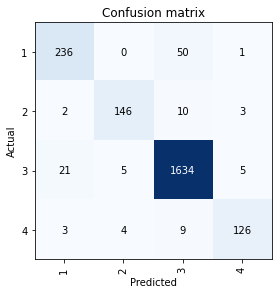

In [15]:
learnB1_n = Learner(data, models.efficientnet.EfficientNetB1(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=nn.CrossEntropyLoss(),
               metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB1_n.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB1_n)
interp.plot_confusion_matrix()

## Weighted loss

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.579423,0.553899,0.923282,0.863174,00:42
1,0.540621,0.554271,0.917073,0.856202,00:42
2,0.507359,0.490056,0.941020,0.907389,00:41
3,0.486065,0.520244,0.932151,0.885504,00:41
4,0.478371,0.507929,0.939246,0.895325,00:41
5,0.474685,0.528420,0.926386,0.870439,00:43
6,0.469325,0.490780,0.951663,0.925122,00:44
7,0.442804,0.468179,0.947228,0.910469,00:43
8,0.446464,0.455247,0.954767,0.922127,00:42
9,0.446448,0.503448,0.935255,0.889118,00:42


Better model found at epoch 0 with accuracy value: 0.9232816100120544.
Better model found at epoch 2 with accuracy value: 0.9410199522972107.
Better model found at epoch 6 with accuracy value: 0.9516629576683044.
Better model found at epoch 8 with accuracy value: 0.9547671675682068.
Better model found at epoch 12 with accuracy value: 0.9552106261253357.
Epoch 14: early stopping


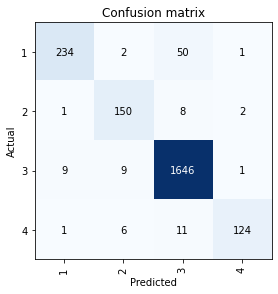

In [13]:
learnB1_im = Learner(data, models.efficientnet.EfficientNetB1(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
class_weights=torch.FloatTensor(weights).cuda()
learnB1_im.crit = nn.CrossEntropyLoss(weight=class_weights)
learnB1_im.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB1_im)
interp.plot_confusion_matrix()

## LabelSmoothing

Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.578463,0.522359,0.930377,0.876204,00:42
1,0.532475,0.542588,0.929933,0.874779,00:42
2,0.484074,0.578107,0.921064,0.857503,00:43
3,0.480073,0.492388,0.936142,0.886322,00:43
4,0.471612,0.703070,0.834146,0.819554,00:43
5,0.469308,0.484604,0.942350,0.900291,00:43
6,0.444591,0.481351,0.942794,0.906209,00:43
7,0.451999,0.493587,0.933925,0.903202,00:43
8,0.438621,0.497152,0.938359,0.897903,00:43
9,0.440024,0.491712,0.942794,0.904136,00:43


Better model found at epoch 0 with accuracy value: 0.9303769469261169.
Better model found at epoch 3 with accuracy value: 0.9361419081687927.
Better model found at epoch 5 with accuracy value: 0.9423503279685974.
Better model found at epoch 6 with accuracy value: 0.9427937865257263.
Better model found at epoch 11 with accuracy value: 0.9476718306541443.
Epoch 12: early stopping


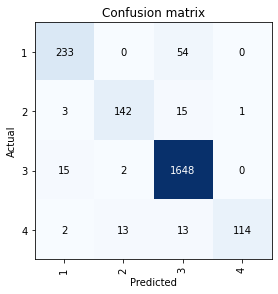

In [14]:
learnB1_ls = Learner(data, models.efficientnet.EfficientNetB1(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB1_ls.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB1_ls)
interp.plot_confusion_matrix()

# EfficientNet B2

## Normal training

In [ ]:
learnB2 = Learner(data, models.efficientnet.EfficientNetB2(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=nn.CrossEntropyLoss(),
               metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB2.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB2)
interp.plot_confusion_matrix()

## Weighted loss

In [ ]:
learnB2_im = Learner(data, models.efficientnet.EfficientNetB2(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
class_weights=torch.FloatTensor(weights).cuda()
learnB2_im.crit = nn.CrossEntropyLoss(weight=class_weights)
learnB2_im.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB2_im)
interp.plot_confusion_matrix()

Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.557440,0.531308,0.926386,0.867715,00:43
1,0.537311,0.515456,0.936142,0.886811,00:43
2,0.510865,0.519743,0.935698,0.878069,00:43
3,0.484014,0.522410,0.936142,0.883076,00:43
4,0.484523,0.538910,0.919290,0.866892,00:43
5,0.471093,0.503065,0.938359,0.893296,00:43
6,0.456920,0.491543,0.935255,0.882000,00:43
7,0.444871,0.499058,0.939690,0.892541,00:42
8,0.438008,0.490446,0.942350,0.898678,00:42
9,0.454870,0.509332,0.943681,0.907338,00:43


Better model found at epoch 0 with accuracy value: 0.9263858199119568.
Better model found at epoch 1 with accuracy value: 0.9361419081687927.
Better model found at epoch 5 with accuracy value: 0.9383592009544373.
Better model found at epoch 7 with accuracy value: 0.939689576625824.
Better model found at epoch 8 with accuracy value: 0.9423503279685974.
Better model found at epoch 9 with accuracy value: 0.9436807036399841.
Better model found at epoch 10 with accuracy value: 0.9454545378684998.
Better model found at epoch 11 with accuracy value: 0.9494456648826599.
Better model found at epoch 14 with accuracy value: 0.9525498747825623.


## LabelSmoothing

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.565217,0.650538,0.910865,0.841616,00:43
1,0.535530,0.565585,0.929490,0.898450,00:43
2,0.506205,0.510770,0.939690,0.903176,00:43
3,0.483441,0.501052,0.945898,0.908633,00:43
4,0.487578,0.518997,0.946341,0.905430,00:43
5,0.461596,0.488924,0.946785,0.910719,00:43
6,0.454076,0.488330,0.938803,0.896186,00:43
7,0.445840,0.488088,0.942350,0.893358,00:43
8,0.447028,0.518940,0.924169,0.883370,00:43
9,0.439035,0.499356,0.949889,0.916556,00:43


Better model found at epoch 0 with accuracy value: 0.9108647704124451.
Better model found at epoch 1 with accuracy value: 0.9294900298118591.
Better model found at epoch 2 with accuracy value: 0.939689576625824.
Better model found at epoch 3 with accuracy value: 0.9458979964256287.
Better model found at epoch 4 with accuracy value: 0.9463414549827576.
Better model found at epoch 5 with accuracy value: 0.9467849135398865.
Better model found at epoch 9 with accuracy value: 0.9498891234397888.
Better model found at epoch 10 with accuracy value: 0.9547671675682068.
Epoch 16: early stopping
Better model found at epoch 16 with accuracy value: 0.9565410017967224.


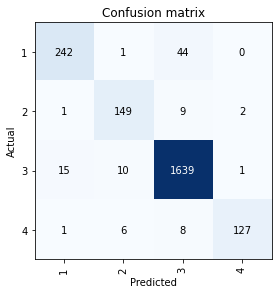

In [16]:
learnB2_ls = Learner(data, models.efficientnet.EfficientNetB2(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='macro',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB2_ls.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB2_ls)
interp.plot_confusion_matrix()

# Test set

In [ ]:
!wget https://www.dropbox.com/s/2k2tj2iwjikeiu9/test.zip?dl=1 -O test.zip

--2020-06-19 09:47:38--  https://www.dropbox.com/s/2k2tj2iwjikeiu9/test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/2k2tj2iwjikeiu9/test.zip [following]
--2020-06-19 09:47:38--  https://www.dropbox.com/s/dl/2k2tj2iwjikeiu9/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc424fb5f5ea587643279b97794b.dl.dropboxusercontent.com/cd/0/get/A58VTpsOAqEBVKb4KXthFlYZRX2QJJXvU6t_ufZ5AotuUwePJ9DHbpRsUeLkfTo5wlazMxHGSazfhv6mXMQUwrmb0RUysDxD4sQzsdD2m13zSwGhLMZbHSh0oZJkVaqsWhQ/file?dl=1# [following]
--2020-06-19 09:47:39--  https://uc424fb5f5ea587643279b97794b.dl.dropboxusercontent.com/cd/0/get/A58VTpsOAqEBVKb4KXthFlYZRX2QJJXvU6t_ufZ5AotuUwePJ9DHbpRsUeLkfTo5wlazMxHGSazfhv6mXMQUwrmb0RUysDxD4sQzsdD2m13zSwGhLMZbHSh0o

In [ ]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/images/
  inflating: test/images/20190402163258_OBJ_0_855_351.png  
  inflating: test/images/20190402163953_OBJ_2_685_452.png  
  inflating: test/images/20190402164018_OBJ_3_762_481.png  
  inflating: test/images/20190402164058_OBJ_1_613_524.png  
  inflating: test/images/20190402164113_OBJ_2_337_489.png  
  inflating: test/images/20190402165159_OBJ_0_1164_216.png  
  inflating: test/images/20190402165310_OBJ_4_610_96.png  
  inflating: test/images/20190402165451_OBJ_8_711_66.png  
  inflating: test/images/20190402165536_OBJ_0_207_750.png  
  inflating: test/images/20190402165608_OBJ_3_482_279.png  
  inflating: test/images/20190402165615_OBJ_3_688_506.png  
  inflating: test/images/20190402165615_OBJ_5_987_198.png  
  inflating: test/images/20190402165615_OBJ_6_783_62.png  
  inflating: test/images/20190402165648_OBJ_5_855_465.png  
  inflating: test/images/20190402165700_OBJ_1_947_201.png  
  inflating: test/images/2019040216570

## Model ensemble

In [ ]:
def ensemble_predition(models,test_path,test_img):
    img = open_image(test_path + test_img)
    
    sum_pred = None
    for m in models:
      if sum_pred is None:
        sum_pred = (m.predict(img))[2]
      else:
        sum_pred += (m.predict(img))[2]
    
    #ensemble average
    prediction = sum_pred / len(models)
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    return predicted_label+1

In [ ]:
ensemble_predition([],'test/images/','20190404114628_OBJ_26_771_485.png')

tensor([-0.5168, -0.2171, -0.6676,  2.3240])


4

In [ ]:
submission_data = []

In [ ]:
test_path = 'test/images/'

In [ ]:
from tqdm import tqdm 
with tqdm(total=len(os.listdir(test_path))) as pbar:       
    #test all test images
    for img in os.listdir(test_path):
        label = ensemble_predition(test_path, img)
        new_np_array = np.array([])
        submission_data.append([img, label])
        pbar.update(1)



100%|██████████| 1991/1991 [02:40<00:00, 12.37it/s]


In [ ]:
submission_data

[['20190404111514_OBJ_8_125_716.png', 3],
 ['20190404111852_OBJ_11_1090_738.png', 3],
 ['20190404110207_OBJ_12_640_419.png', 3],
 ['20190404112943_OBJ_22_905_199.png', 3],
 ['20190404111124_OBJ_23_743_101.png', 3],
 ['20190404105610_OBJ_3_922_159.png', 3],
 ['20190402170004_OBJ_0_1027_682.png', 4],
 ['20190404110116_OBJ_12_650_228.png', 3],
 ['20190404114327_OBJ_9_81_434.png', 3],
 ['20190404110731_OBJ_10_56_620.png', 1],
 ['20190404112417_OBJ_5_335_103.png', 4],
 ['20190404110246_OBJ_2_74_744.png', 3],
 ['20190404113135_OBJ_5_594_870.png', 3],
 ['20190404112917_OBJ_1_1098_691.png', 2],
 ['20190404110735_OBJ_8_1121_663.png', 1],
 ['20190404113545_OBJ_29_302_44.png', 3],
 ['20190404110650_OBJ_13_1064_364.png', 2],
 ['20190404114404_OBJ_15_287_607.png', 3],
 ['20190404113653_OBJ_5_168_871.png', 1],
 ['20190404110329_OBJ_42_294_222.png', 3],
 ['20190404114505_OBJ_29_53_162.png', 3],
 ['20190404110237_OBJ_8_806_247.png', 1],
 ['20190404113932_OBJ_8_542_519.png', 3],
 ['20190404110154_OBJ_3

In [ ]:
subObj =[{'Filename': filename, "Class": str(cl)} for filename,cl in submission_data]

In [ ]:
subObj

[{'Class': '3', 'Filename': '20190404111514_OBJ_8_125_716.png'},
 {'Class': '3', 'Filename': '20190404111852_OBJ_11_1090_738.png'},
 {'Class': '3', 'Filename': '20190404110207_OBJ_12_640_419.png'},
 {'Class': '3', 'Filename': '20190404112943_OBJ_22_905_199.png'},
 {'Class': '3', 'Filename': '20190404111124_OBJ_23_743_101.png'},
 {'Class': '3', 'Filename': '20190404105610_OBJ_3_922_159.png'},
 {'Class': '4', 'Filename': '20190402170004_OBJ_0_1027_682.png'},
 {'Class': '3', 'Filename': '20190404110116_OBJ_12_650_228.png'},
 {'Class': '3', 'Filename': '20190404114327_OBJ_9_81_434.png'},
 {'Class': '1', 'Filename': '20190404110731_OBJ_10_56_620.png'},
 {'Class': '4', 'Filename': '20190404112417_OBJ_5_335_103.png'},
 {'Class': '3', 'Filename': '20190404110246_OBJ_2_74_744.png'},
 {'Class': '3', 'Filename': '20190404113135_OBJ_5_594_870.png'},
 {'Class': '2', 'Filename': '20190404112917_OBJ_1_1098_691.png'},
 {'Class': '1', 'Filename': '20190404110735_OBJ_8_1121_663.png'},
 {'Class': '3', 'F

In [ ]:
import json

In [ ]:
to_json= json.dumps(subObj)

In [ ]:
to_json

'[{"Filename": "20190404111514_OBJ_8_125_716.png", "Class": "3"}, {"Filename": "20190404111852_OBJ_11_1090_738.png", "Class": "3"}, {"Filename": "20190404110207_OBJ_12_640_419.png", "Class": "3"}, {"Filename": "20190404112943_OBJ_22_905_199.png", "Class": "3"}, {"Filename": "20190404111124_OBJ_23_743_101.png", "Class": "3"}, {"Filename": "20190404105610_OBJ_3_922_159.png", "Class": "3"}, {"Filename": "20190402170004_OBJ_0_1027_682.png", "Class": "4"}, {"Filename": "20190404110116_OBJ_12_650_228.png", "Class": "3"}, {"Filename": "20190404114327_OBJ_9_81_434.png", "Class": "3"}, {"Filename": "20190404110731_OBJ_10_56_620.png", "Class": "1"}, {"Filename": "20190404112417_OBJ_5_335_103.png", "Class": "4"}, {"Filename": "20190404110246_OBJ_2_74_744.png", "Class": "3"}, {"Filename": "20190404113135_OBJ_5_594_870.png", "Class": "3"}, {"Filename": "20190404112917_OBJ_1_1098_691.png", "Class": "2"}, {"Filename": "20190404110735_OBJ_8_1121_663.png", "Class": "1"}, {"Filename": "20190404113545_OB

In [ ]:
with open('result.json', 'w') as outfile:
    json.dump(subObj,outfile)